<a href="https://colab.research.google.com/github/sudheerranjan/tigergraph/blob/main/Tigergraph_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain openai pyTigerGraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.4/263.4 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.6 MB/s eta 0:00:00


In [2]:
from pyTigerGraph import TigerGraphConnection
import json

In [ ]:
hostName = "https://c4f8de85fcad41c1894e19a27e8c8160.i.tgcloud.io"
graphName = "MyGraph"
userName = "sudheerranjan"
password = "************"

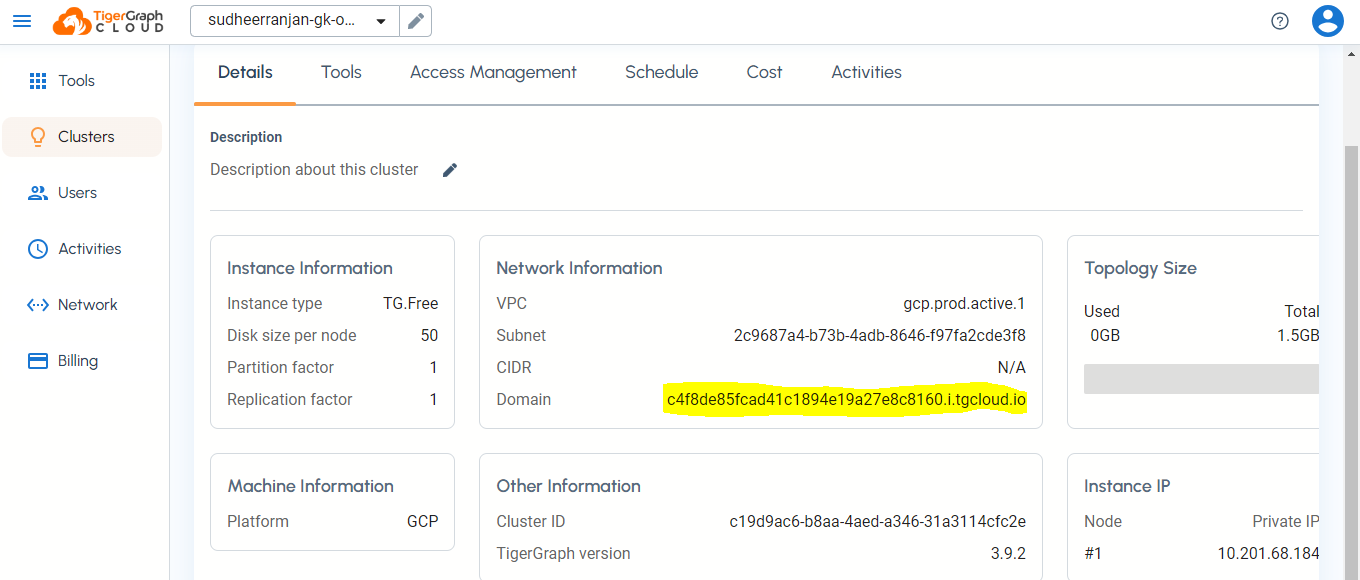

In [ ]:
conn = TigerGraphConnection(
    host=hostName,
    graphname = graphName,
    username=userName,
    password=password
)

In [ ]:
secret = conn.createSecret(alias="my_secret_092423")

In [ ]:
graph = TigerGraphConnection(host=hostName, graphname=graphName)
authToken = graph.getToken(secret)
authToken = authToken[0]

In [ ]:
conn = TigerGraphConnection(
    host=hostName,
    graphname = graphName,
    username=userName,
    password=password,
    gsqlSecret = secret,
    apiToken=authToken
)

In [ ]:
conn.getVertexCount('*')

{'Patient': 1010,
 'Claim': 10022,
 'Prescriber': 104,
 'Specialty': 4,
 'SubSpecialty': 18}

In [ ]:
# results = conn.getSchema()
# print(json.dumps(results, indent=2))

In [ ]:
from langchain.agents import AgentType, initialize_agent, load_tools
from langchain.chat_models import ChatOpenAI
from langchain.llms.base import LLM
from langchain.tools import BaseTool, StructuredTool, Tool, tool
from langchain.tools.base import ToolException
from langchain.chains import LLMChain
from langchain import OpenAI
from langchain.prompts import PromptTemplate
from langchain.callbacks.manager import AsyncCallbackManagerForToolRun, CallbackManagerForToolRun
from typing import Optional, Type

In [ ]:
print(conn.getVertexTypes())
print(conn.getEdgeTypes())

['Specialty', 'SubSpecialty', 'Prescriber', 'Claim', 'Patient']
['submitted_by', 'associated', 'specialty_subspecialty', 'subspecialty_prescriber', 'referral']


In [ ]:
class MapQuestionToSchema(BaseTool):
    name = "MapQuestionToSchema"
    description = "Always run first to map the query to the graph's schema"
    conn: TigerGraphConnection = None
    llm: LLM = None
    handle_tool_error: bool = True

    def __init__(self, conn, llm):
        super().__init__()
        self.conn = conn
        self.llm = llm

    def _run(self, query: str) -> str:
        """Use the tool."""
        question_restate = """Replace the entities mentioned in the question to one of these choices: {vertices}.
                      Replace the relationships mentioned in the question to one of these choices: {edges}.
                      Generate the complete question with the appropriate replacements. Keep the case of the schema elements the same.
                      If there are no replacements to be made, restate the question.
                      Example: How many universities are there?
                      Response: How many vertices are University Vertexes?
                      Example: What is the schema?
                      Response: What is the schema?
                      Example: How many transactions are there?
                      Response: How many TRANSACTION Edges are there?
                      QUESTION: {question}
                      RESTATED: """

        RESTATE_QUESTION_PROMPT = PromptTemplate(
            template=question_restate, input_variables=["question", "vertices", "edges"]
        )

        restate_chain = LLMChain(llm=self.llm, prompt=RESTATE_QUESTION_PROMPT)
        # apply allows you to run the chain against a list of inputs
        restate_q = restate_chain.apply([{"vertices": [x + " Vertex" for x in self.conn.getVertexTypes()], # + [x + " Edge" for x in conn.getEdgeTypes()],
                                          "question": query,
                                          "edges": [x + " Edge" for x in self.conn.getEdgeTypes()]}])[0]["text"]
        return restate_q

    async def _arun(self) -> str:
        """Use the tool asynchronously."""
        raise NotImplementedError("custom_search does not support async")

    def _handle_error(self, error:ToolException) -> str:
        return  "The following errors occurred during tool execution:" + error.args[0]+ "Please ask for human input if they asked their question correctly."

In [ ]:
class GenerateFunction(BaseTool):
    name = "GenerateFunction"
    description = "Generate a pyTigerGraph function call"
    conn: TigerGraphConnection = None
    llm: LLM = None
    handle_tool_error: bool =True

    def __init__(self, conn, llm):
        super().__init__()
        self.conn = conn
        self.llm = llm

    def _run(self, question: str) -> str:
        prompt_template = """Use the vertex types, edge types to write the pyTigerGraph function call to answer the question using a
                            pyTigerGraph connection.
                            For example, if a count of vertices is asked for, use getVertexCount().
                            If a count of edges from a specific vertex is asked for, use getEdgeCountFrom().
                            If multiple entites are referred to in the question, use runInstalledQuery() when necessary.
                            If there is not a natural answer to the question, ask a human for help.
                            Parameters of queries to be replaced are denoted <INSERT_ID_HERE>.
                            Vertex Types: {vertices}
                            Edge Types: {edges}
                            Queries: {queries}
                            Question: {question}
                            Python Call: conn."""

        PROMPT = PromptTemplate(
            template=prompt_template, input_variables=["question", "vertices", "queries", "edges"]
        )
        queries = conn.getInstalledQueries()
        [queries[x]["parameters"].pop("read_committed") for x in queries] #remove read_committed
        inputs = [{"question": question,
                    "vertices": self.conn.getVertexTypes(),
                    "edges": self.conn.getEdgeTypes(),
                    "queries": [{queries[x]["alternative_endpoint"].split("/")[-1]: queries[x]["parameters"]} for x in queries]
                  }]

        chain = LLMChain(llm=self.llm, prompt=PROMPT)
        generated = chain.apply(inputs)[0]["text"]
        return generated

    async def _arun(self) -> str:
        """Use the tool asynchronously."""
        raise NotImplementedError("custom_search does not support async")

    def _handle_error(error:ToolException) -> str:
        return  "The following errors occurred during tool execution:" + error.args[0]+ "Please ask for human input if they asked their question correctly."

In [ ]:
class ExecuteFunction(BaseTool):
    name = "ExecuteFunction"
    description = "Execute a pyTigerGraph function"
    conn: TigerGraphConnection = None
    handle_tool_error: bool =True

    def __init__(self, conn):
        super().__init__()
        self.conn = conn

    def _run(self, function: str) -> str:
        try:
            loc = {}
            print("function given",function)
            exec("res = conn."+function, {"conn": conn}, loc) #exec() function takes two arguments:code to be executed, dictionary of global/local variables
            # res = conn."+function into a code object
            # It executes the code object in the given namespace, which contains the variable conn and the local variables in the dictionary loc.
            # It assigns the result of the execution to the variable res
            return loc["res"]
        except:
            raise ToolException("The function {} did not execute directly. Please rephrase your question and try again".format(function))

    async def _arun(self) -> str:
        """Use the tool asynchronously."""
        raise NotImplementedError("custom_search does not support async")

    def _handle_error(error:ToolException) -> str:
        return  "The following errors occurred during tool execution:" + error.args[0]+ "Please ask for human input if they asked their question correctly."

In [ ]:
llm = OpenAI(temperature=0, model_name="text-davinci-003")

In [ ]:
tools = [MapQuestionToSchema(conn, llm), GenerateFunction(conn, llm),  ExecuteFunction(conn)]

In [ ]:
agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
)

In [ ]:
agent.run("How many Prescribers are there?")



> Entering new AgentExecutor chain...


 I need to find out how many Prescribers there are in the graph
Action: MapQuestionToSchema
Action Input: How many Prescribers are there?


Observation:  How many Prescriber Vertices are there?
Thought:

 I need to generate a function to count the Prescriber Vertices
Action: GenerateFunction
Action Input: Count the Prescriber Vertices


Observation: getVertexCount('Prescriber')
Thought:

 I need to execute the function to get the count
Action: ExecuteFunction
Action Input: getVertexCount('Prescriber')


Observation: 104
Thought:

 I now know the final answer
Final Answer: There are 104 Prescribers.

> Finished chain.


'There are 104 Prescribers.'